[Table of contents](../toc.ipynb)

# Ordinary differential equations

We will compare different discretization schemes to solve ordinary differential equations (ODE) in this mini project. The goal is that you have gathered practical experience in
 * explicit Euler, 
 * and Runge-Kutta solver for ODEs.
 
We will solve and compare the solution of the basic ODE 

$y'(t) = y(t)$

with exact solution, and numerical ODE solvers like it was done in section 1.2.6 [[Burg2013]](../references.bib) for Matlab.

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

import sympy as sp
import numpy as np

## Exact solution

The exact solution is likely very simple to solve for you and you do not need Python for it, but let us compute with SymPy briefly.

First, we need to define a symbol and a function, which should result in the given function $y'(t) = y(t)$.

In [3]:
y = sp.Function('y')
t = sp.symbols('t')

dgl = sp.Eq(y(t).diff(t), y(t))
dgl

Eq(Derivative(y(t), t), y(t))

We can compute now with SymPy the exact solution with and without initial condition.

In [4]:
sp.dsolve(dgl, y(t))

Eq(y(t), C1*exp(t))

The solution with initial condition becomes:

In [5]:
sp.dsolve(dgl, y(t), ics={y(0): 3})

Eq(y(t), 3*exp(t))

It is obvious that the integration constant $C_1$ from the solution without initial condition has always the value 
$C_1 = y(0)$.

Therefore, we can define a function to compute the exact solution on different initial conditions.

In [6]:
def exact_solution(time, init):
    return init * np.exp(time)

And a loop computes the solutions for each initial condition.

In [7]:
time = np.arange(0, 3, 0.1)
init = np.arange(0, 4, 0.5)

dgl_exact = np.zeros((init.size, time.size))

for idx, value in enumerate(init):
    dgl_exact[idx,:] = exact_solution(time, value)

The next plot shows the solutions.

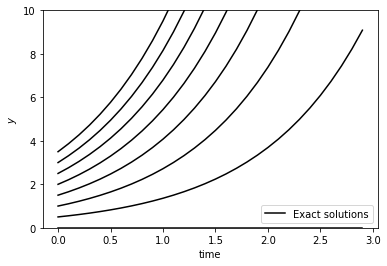

In [8]:
plt.figure()
for row in np.ndindex(dgl_exact.shape[0]):
    plt.plot(time, dgl_exact[row], 'k-')
plt.ylim([0, 10])
plt.xlabel("time")
plt.ylabel("$y$")
plt.legend(["Exact solutions"])

plt.show()

## Numerical solution

### Runge-Kutta

Now we want to apply SciPy to compute the numerical solution with Runge-Kutta numerical solver. SciPy uses the `RK45`, which is an explicit Runge-Kutta of order four, where the step size is approximated from order five method. The classical Runge-Kutta of order four follows

$\begin{align}
r_1 &= f(t_i, y_i)\\
r_2 &= f(t_i + \frac{1}{2} \Delta t, y_i + \frac{1}{2} \Delta t r_1)\\
r_3 &= f(t_i + \frac{1}{2} \Delta t, y_i + \frac{1}{2} \Delta t r_2)\\
r_4 &= f(t_i + \Delta t, y_i + \Delta t r_3)\\
y_{i+1} &= y_i + \frac{1}{6} \Delta t (r_1 + 2 r_2 + 2 r_3 + r_4),
\end{align}$

see equation (1.105) in [[Burg2013]](../references.bib).

First, we need to define the function which should be solved.

In [9]:
def equation(t, y):
    """Return right hand side of d/dt y(t) = y(t)"""
    return [1 * y[0]]

Now, we can use `scipy.intergrate` to solve the solution with Runge-Kutta solver.

In [10]:
from scipy.integrate import solve_ivp

time_span = [0, 3]
init = [1]
dgl_RK45 = solve_ivp(equation, time_span, init, method='RK45', t_eval=time)

And now we plot this solution for initial value $y(0)=1$.

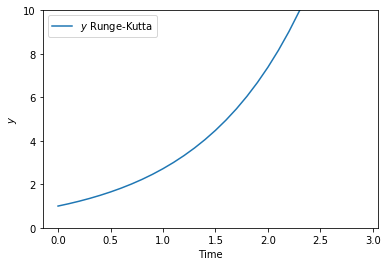

In [11]:
plt.figure()
plt.plot(time, dgl_RK45.y[0, :])
plt.legend(["$y$ Runge-Kutta"])
plt.xlabel("Time")
plt.ylabel("$y$")
plt.ylim([0, 10])
plt.show()

### Explicit Euler

<img src="euler.png" alt="Exercise" width="300" align="right">

The explicit Euler method (forward Euler) is the simplest one step numerical solver we can implement by ourself.

It is based on the approximation

$y'(t_i) \approx \dfrac{y(t_{i+1}) - y(t_i)}{\Delta t}$,

$y(t_{i+1}) - y(t_i) \approx \Delta t f(t_i, y(t_i))$,

and the solution becomes,

$y_{i+1} = y_i + \Delta t f(t_i, y_i)$,

where $\Delta t$ is the step size and $f(t_i, y_i)$ is right hand side of $y'(t) = f(t, y(t))$, see section 1.2.6 [[Burg2013]](../references.bib).

In [12]:
def solve_eeuler(func, time_vec, delta_t, inc):
    """Forwar Euler for DGL of type d/dt y = f(t, y(t))"""
    y = np.zeros(time_vec.size)   
    y[0] = inc
    
    for idx, t in enumerate(time_vec[1:]):
        f = func(t, np.array([y[idx]]))[0]
        y[idx + 1] = y[idx] + delta_t * f
    return y

In [13]:
dgl_eeuler = solve_eeuler(func=equation, time_vec=time, delta_t=0.1, inc=1.0)

In [14]:
time2 = np.arange(0, 3, 0.3)
dgl_eeuler2 = solve_eeuler(func=equation, time_vec=time2, delta_t=0.3, inc=1.0)

### Implicit Euler

The implicit Euler or backward Euler solver looks very similar to explicit Euler. However, here the computation $f(t_{i+1}, y_{i+1})$ is required which makes this method computational more expensive but ensure stability. The implicit Euler is

$y_{t+1} = y_i + \Delta t f(t_{i+1}, y_{i+1})$.

However, we will skip the implementation of implicit Euler herein.

### Results

The next plot shows all solutions together. The large step size in `dgl_eeuler2` causes large discretization error. Add to this, Euler method can also cause unstable solutions if the step size is to large for the given problem.

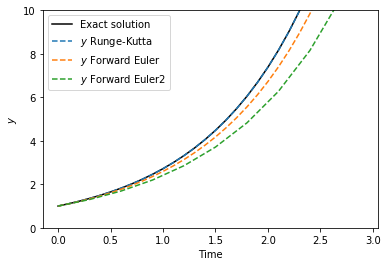

In [15]:
plt.figure()
plt.plot(time, dgl_exact[2], 'k-')
plt.plot(time, dgl_RK45.y[0, :], '--')
plt.plot(time, dgl_eeuler, '--')
plt.plot(time2, dgl_eeuler2, '--')
plt.legend(["Exact solution", "$y$ Runge-Kutta", "$y$ Forward Euler", "$y$ Forward Euler2"])
plt.xlabel("Time")
plt.ylabel("$y$")
plt.ylim([0, 10])
plt.show()

Finally, let us compute the error of Runge-Kutta and forward Euler solver compared with exact solution.

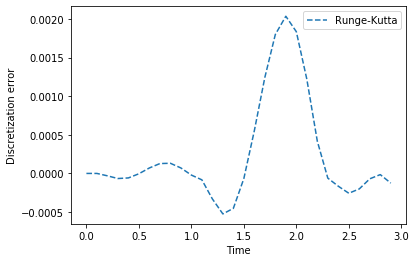

In [16]:
plt.figure()
plt.plot(time, dgl_exact[2] - dgl_RK45.y[0, :], '--')
plt.legend(["Runge-Kutta"])
plt.xlabel("Time")
plt.ylabel("Discretization error")
plt.show()

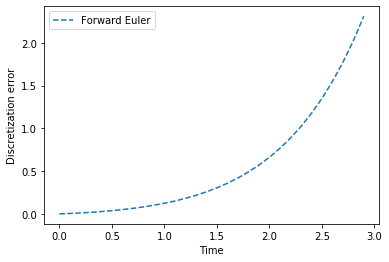

In [17]:
plt.figure()
plt.plot(time, dgl_exact[2] - dgl_eeuler, '--')
plt.legend(["Forward Euler"])
plt.xlabel("Time")
plt.ylabel("Discretization error")
plt.show()

It is clearly visible that Runge-Kutta provides much better accuracy than explicit Euler. For more ODE solvers and their accuracy consult pages 75-80 in [[Burg2013]](../references.bib).

## Exercise:  ODE mini project

<img src="../_static/exercise.png" alt="Exercise" width="75" align="left">

Please find the exact and Runge-Kutta solution for the mechanical oscillator system

$m\ddot{x}(t) + r \dot{x}(t) + k x(t) = K(t)$,

where $m$ denotes mass, $r$ damping constant, $k$ spring constant, and $K(t)$ is a time varying external force. We are looking for the displacement $x(t)$.

<img src="spring_mass_damper.png" alt="Spring mass damper" width="500">

You can assume that $K(t) = K_0 \cos \omega t$.